<a href="https://colab.research.google.com/github/ahmadryan/MLTSA_RQudsi/blob/master/HW1_RQudsi/HW1_RQudsi_e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods. 

Notes: 

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
import pandas as pd
import pylab as pl
import numpy as np

%pylab inline

# I have created a stylesheet to define default plot behaviors. 
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

find the link to the *raw* input file on github in the HW1 folder https://github.com/fedhere/MLTSA_FBianco/tree/master/HW1

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW1/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space. (Note: we mean logbase 10, use ```numpy.log10()```


In [3]:
grbAG["logtime"] = np.log10( grbAG.time )
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B. 

The information about the photometric band is stored in the variable ```grbAG.filter```. If I wanted to retrieve all magnitudes for filter 'V' I would do ```grbAG.loc[grbAG["filter"] == f, "mag"]```.

Plot the data with different colors for different photometric bands. 

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


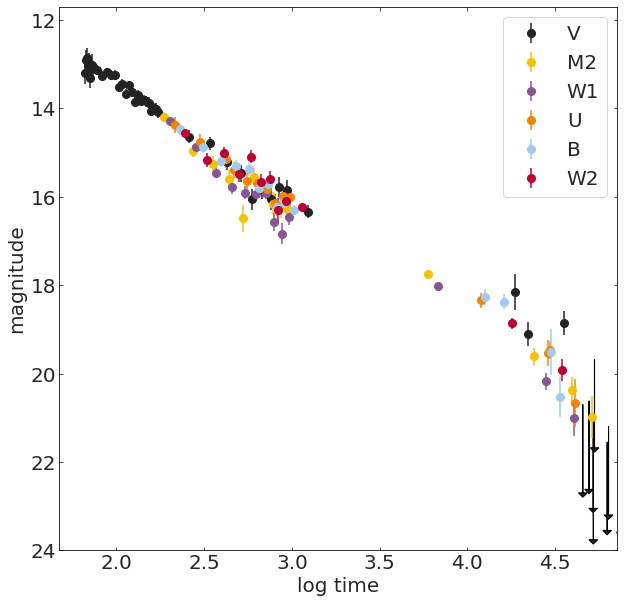

In [4]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():

    new_df = grbAG.loc[grbAG["filter"] == f ]
    pl.errorbar( new_df.logtime, new_df.mag, yerr=new_df.magerr, ls='', marker='o', ms=8, label=f )
    

# plot the upperlimits as arrows 
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)          
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows. 

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [5]:
x = grbAG[grbAG.upperlimit == 0].logtime.values

X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)), x]

y = grbAG.loc[grbAG.upperlimit == 0].mag

print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [6]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```. 
To remove the upper limits you can "broadcast" the data: in pandas that looks like 

```grbAG.loc[grbAG.upperlimit == 0]```



In [7]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression

#sklearn is an object oriented package. You will call the function which will create a model (model selection) then fit it to the data separately (model fitting)

lr = LinearRegression()
lr.fit( X, y )

#this will create new properties of the model instance: the intercept and coefficients!

print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [8]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(x, intercept, slope):

    return slope*x + intercept

def l1(args, x, y):
    a, b = args
    fx = line( x, b, a )
    diff = sum( abs( fx - y ) )

    return diff #see notes to know what this should be!

initialGuess = (10, 1) #this can be important, a bad choice can get us stuck in a local minimum. But for this simple problem we can just guess whatever

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

      fun: 26.30433938779833
 hess_inv: array([[ 0.00759339, -0.01591227],
       [-0.01591227,  0.03413205]])
      jac: array([-1.95810723,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 252
      nit: 11
     njev: 61
   status: 2
  success: False
        x: array([2.64023375, 8.22681531])

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23



# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [9]:
def chi2(args, x, y, s):
    a, b = args
    fx = line( x, b, a )

    return sum( (fx - y )**2/s ) #see notes

s = grbAG[grbAG.upperlimit == 0].magerr # assign the uncertainties to s. Its the column names "magerr"

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

      fun: 58.49837428948376
 hess_inv: array([[ 0.00139785, -0.00381294],
       [-0.00381294,  0.01113154]])
      jac: array([4.76837158e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([2.49968626, 8.58159553])

best fit parameters from the minimization of the chi squared: slope 2.50, intercept 8.58


# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


Text(0.5, 0, 'log time (seconds after explosion)')

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


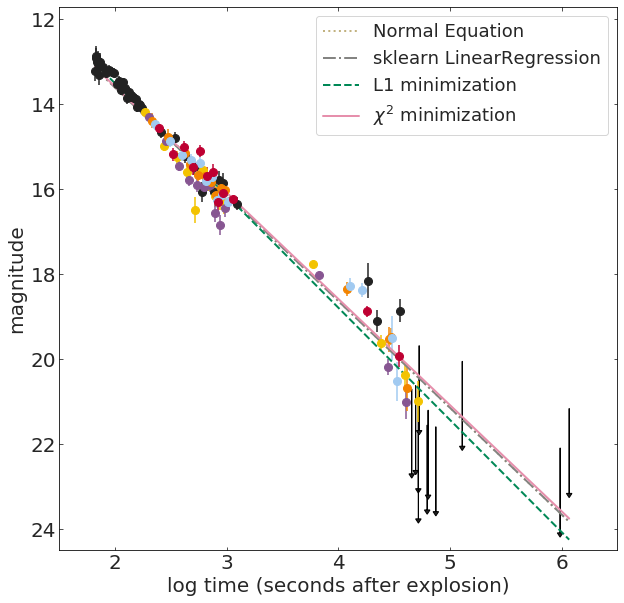

In [10]:
def plotline( x, m, c, marker=None, ls=None, lw=None, label=None ):

    y = m*x + c

    ax.plot( x, y, marker=marker, ls=ls, lw=2, label=label )

ax = pl.figure(figsize=(10,10)).add_subplot(111)

# Plot the actual data

for f in grbAG["filter"].unique():

    new_df = grbAG.loc[grbAG["filter"] == f ]
    pl.errorbar( new_df.logtime, new_df.mag, yerr=new_df.magerr, ls='', marker='o', ms=8 )

# plot the upperlimits as arrows 
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

#plot the models

x_all = grbAG.logtime

#normal equation
plotline( x_all, theta_best[1], theta_best[0], ls=':', label='Normal Equation' )
         
#sklearn
plotline( x_all, lr.coef_[1], lr.intercept_, ls='-.', label='sklearn LinearRegression' )
         
#minimize L1
plotline( x_all, l1Solution.x[0], l1Solution.x[1], ls='--', label='L1 minimization' )

#minimize chi2
plotline( x_all, chi2Solution.x[0], chi2Solution.x[1], ls='-', label=r'$\chi^2$ minimization' )
        
pl.legend( fontsize=18 )

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (seconds after explosion)", fontsize=20)

Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

Number of photons reaching the telescope/detector decreases with time and thus error bars of magnitude gradually increases. Also, since magnitude and time appears to have a linear relationship on a log-linear plot, it implies that the flux received at a point as a consequence of a Gamma Ray Burst decreases with time as a power law with exponent of -1.01 (for this case).

# Create a table with the results of each method
(see here for table syntax in markdown) https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables

|method | slope | intercept |
| ------------- |:-------------:| -----:|
|Normal Equation | 2.51 | 8.58 |
|sklearn Linear Regression | 2.51 | 8.58 |
| L1 minimization | 2.64 | 8.23 |
|$\chi^2$ minimization| 2.50 | 8.58 |
| || |
|Mean values| 2.54 | 8.49|
|Standard deviation| 0.07| 0.18|